In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from os import listdir
from os.path import isfile, join
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

Using TensorFlow backend.


In [2]:
  dic_localidades = {
        'RiesgoBariloche':'Bariloche',
        'RiesgoBuenosAires':'Buenos Aires',
        'RiesgoCABACABANA':'CABA',
        'RiesgoChacoNA':'Chaco',
        'RiesgoCórdobaCórdoba':'Córdoba',
        'RiesgoEntreRiosRíos':'Entre Ríos',
        'RiesgoJujuyJujuy':'Jujuy',
        'RiesgoLaRiojaRioja':'La Rioja',
        'RiesgoMendozaMendoza':'Mendoza',
        'RiesgoNeuquénNeuquén':'Neuquén',
        'RiesgoRioNegro':'Río Negro',
        'RiesgoSaltaSalta':'Salta',
        'RiesgoSantaCruzSantaCruz':'Santa Cruz',
        'RiesgoSantaFeSantaFe':'Santa Fe',
        'RiesgoTierradelFuegoTierradel':'Tierra del Fuego',
        'RiesgoTucumanTucuman':'Tucumán'
    }

In [3]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
def graph_predictions(l,df_original,y_train_pr,y_test_pr,name):
    plt.plot(df_original) 
    months_tr = np.arange(l,len(y_train_pr)+l) #meses de training
    months_ts = np.arange(len(y_train_pr)+(2*l)+1,len(df_original)-1) #meses de testing
    plt.plot(months_tr,y_train_pr,label='train') #grafico de train results
    plt.plot(months_ts,y_test_pr,label='test') #grafico de test results
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días')
    plt.ylabel('Casos/100 mil hab')
    plt.legend(fontsize=12)
    plt.savefig(dic_localidades[str(name)]+'_fit_2.pdf')
    plt.show()

In [5]:
seed = 7
np.random.seed(seed)

In [6]:
mypath = 'Datos'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
df_train_total = [] #aca guardamos todos los datos

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
n_steps_in = 10
n_steps_out = 10

# armo scaler para los datos

In [8]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    df_train_total.extend(list(train_data.flatten()))

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_total = scaler.fit_transform(np.array(df_train_total).reshape(-1,1))

# ahora armo los datos de train, test y forecast

In [10]:
df_forecast = [] #aca van a estar los datos para hacer el forecasting

In [11]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast.append(df[-20:-10])
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    if file == 'RiesgoBariloche':
        x_train_total, y_train_total = split_sequence(train_data, n_steps_in, n_steps_out)
        x_test_total, y_test_total = split_sequence(test_data, n_steps_in, n_steps_out)
    else:
        #train
        x_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
        x_train_total = np.vstack((x_train_total,x_train))
        y_train_total = np.vstack((y_train_total,y_train))
        #test
        x_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
        x_test_total = np.vstack((x_test_total,x_test))
        y_test_total = np.vstack((y_test_total,y_test))
            

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [12]:
x_train_total = x_train_total.reshape(x_train_total.shape[0],1,x_train_total.shape[1])
x_test_total = x_test_total.reshape(x_test_total.shape[0],1,x_test_total.shape[1])
y_train_total =  y_train_total.reshape(y_train_total.shape[0],y_train_total.shape[1])
y_test_total = y_test_total.reshape(y_test_total.shape[0],y_test_total.shape[1])

In [13]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=32,activation='relu',return_sequences=True,input_shape=(1,n_steps_in)))
model.add(keras.layers.LSTM(units=32,activation='relu',return_sequences=False,input_shape=(1,n_steps_in)))
model.add(keras.layers.Dense(units=n_steps_out))
model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) 
model.summary()
history = model.fit(x_train_total, y_train_total,epochs=1000,batch_size=256,validation_data=(x_test_total,y_test_total),verbose=2) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 32)             5504      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 14,154
Trainable params: 14,154
Non-trainable params: 0
_________________________________________________________________
Train on 3238 samples, validate on 590 samples
Epoch 1/1000
 - 1s - loss: 0.0461 - mse: 0.0461 - val_loss: 1.1594 - val_mse: 1.1594
Epoch 2/1000
 - 0s - loss: 0.0428 - mse: 0.0428 - val_loss: 1.0980 - val_mse: 1.0980
Epoch 3/1000
 - 0s - loss: 0.0393 - mse: 0.0393 - val_loss: 0.9729 - val_mse: 0.9729
Epoch 4/1000
 - 0s - loss: 0.0349 - mse: 0.0349 - val_loss: 0.6931 - val_mse: 

Epoch 85/1000
 - 0s - loss: 9.1268e-04 - mse: 9.1268e-04 - val_loss: 0.0647 - val_mse: 0.0647
Epoch 86/1000
 - 0s - loss: 9.1276e-04 - mse: 9.1276e-04 - val_loss: 0.0785 - val_mse: 0.0785
Epoch 87/1000
 - 0s - loss: 8.8587e-04 - mse: 8.8587e-04 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 88/1000
 - 0s - loss: 8.8205e-04 - mse: 8.8205e-04 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 89/1000
 - 0s - loss: 8.7535e-04 - mse: 8.7535e-04 - val_loss: 0.0740 - val_mse: 0.0740
Epoch 90/1000
 - 0s - loss: 8.6553e-04 - mse: 8.6553e-04 - val_loss: 0.0668 - val_mse: 0.0668
Epoch 91/1000
 - 0s - loss: 8.9373e-04 - mse: 8.9373e-04 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 92/1000
 - 0s - loss: 8.8109e-04 - mse: 8.8109e-04 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 93/1000
 - 0s - loss: 8.6279e-04 - mse: 8.6279e-04 - val_loss: 0.0649 - val_mse: 0.0649
Epoch 94/1000
 - 0s - loss: 8.7711e-04 - mse: 8.7711e-04 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 95/1000
 - 0s - loss: 8.5066e-04 - mse: 8.5066e-04 - v

Epoch 172/1000
 - 0s - loss: 6.1687e-04 - mse: 6.1687e-04 - val_loss: 0.0576 - val_mse: 0.0576
Epoch 173/1000
 - 0s - loss: 6.1865e-04 - mse: 6.1865e-04 - val_loss: 0.0578 - val_mse: 0.0578
Epoch 174/1000
 - 0s - loss: 6.1435e-04 - mse: 6.1435e-04 - val_loss: 0.0577 - val_mse: 0.0577
Epoch 175/1000
 - 0s - loss: 6.1782e-04 - mse: 6.1782e-04 - val_loss: 0.0576 - val_mse: 0.0576
Epoch 176/1000
 - 0s - loss: 6.1368e-04 - mse: 6.1368e-04 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 177/1000
 - 0s - loss: 6.1078e-04 - mse: 6.1078e-04 - val_loss: 0.0580 - val_mse: 0.0580
Epoch 178/1000
 - 0s - loss: 6.0791e-04 - mse: 6.0791e-04 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 179/1000
 - 0s - loss: 6.2218e-04 - mse: 6.2218e-04 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 180/1000
 - 0s - loss: 5.9869e-04 - mse: 5.9869e-04 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 181/1000
 - 0s - loss: 6.0561e-04 - mse: 6.0561e-04 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 182/1000
 - 0s - loss: 6.1432e-04 - mse: 6.1

Epoch 259/1000
 - 0s - loss: 5.0758e-04 - mse: 5.0758e-04 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 260/1000
 - 0s - loss: 5.1842e-04 - mse: 5.1842e-04 - val_loss: 0.0647 - val_mse: 0.0647
Epoch 261/1000
 - 0s - loss: 5.1361e-04 - mse: 5.1361e-04 - val_loss: 0.0661 - val_mse: 0.0661
Epoch 262/1000
 - 0s - loss: 5.0489e-04 - mse: 5.0489e-04 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 263/1000
 - 0s - loss: 4.9962e-04 - mse: 4.9962e-04 - val_loss: 0.0699 - val_mse: 0.0699
Epoch 264/1000
 - 0s - loss: 5.2114e-04 - mse: 5.2114e-04 - val_loss: 0.0645 - val_mse: 0.0645
Epoch 265/1000
 - 0s - loss: 5.2257e-04 - mse: 5.2257e-04 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 266/1000
 - 0s - loss: 5.0809e-04 - mse: 5.0809e-04 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 267/1000
 - 0s - loss: 5.2707e-04 - mse: 5.2707e-04 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 268/1000
 - 0s - loss: 5.0208e-04 - mse: 5.0208e-04 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 269/1000
 - 0s - loss: 5.1272e-04 - mse: 5.1

Epoch 346/1000
 - 0s - loss: 4.7288e-04 - mse: 4.7288e-04 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 347/1000
 - 0s - loss: 4.7580e-04 - mse: 4.7580e-04 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 348/1000
 - 0s - loss: 4.7004e-04 - mse: 4.7004e-04 - val_loss: 0.0575 - val_mse: 0.0575
Epoch 349/1000
 - 0s - loss: 4.7128e-04 - mse: 4.7128e-04 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 350/1000
 - 0s - loss: 4.6146e-04 - mse: 4.6146e-04 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 351/1000
 - 0s - loss: 4.7380e-04 - mse: 4.7380e-04 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 352/1000
 - 0s - loss: 4.7972e-04 - mse: 4.7972e-04 - val_loss: 0.0592 - val_mse: 0.0592
Epoch 353/1000
 - 0s - loss: 4.6826e-04 - mse: 4.6826e-04 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 354/1000
 - 0s - loss: 4.8312e-04 - mse: 4.8312e-04 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 355/1000
 - 0s - loss: 4.9479e-04 - mse: 4.9479e-04 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 356/1000
 - 0s - loss: 4.7563e-04 - mse: 4.7

Epoch 433/1000
 - 0s - loss: 4.3842e-04 - mse: 4.3842e-04 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 434/1000
 - 0s - loss: 4.4418e-04 - mse: 4.4418e-04 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 435/1000
 - 0s - loss: 4.5039e-04 - mse: 4.5039e-04 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 436/1000
 - 0s - loss: 4.3727e-04 - mse: 4.3727e-04 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 437/1000
 - 0s - loss: 4.3961e-04 - mse: 4.3961e-04 - val_loss: 0.0723 - val_mse: 0.0723
Epoch 438/1000
 - 0s - loss: 4.4485e-04 - mse: 4.4485e-04 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 439/1000
 - 0s - loss: 4.4855e-04 - mse: 4.4855e-04 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 440/1000
 - 0s - loss: 4.3490e-04 - mse: 4.3490e-04 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 441/1000
 - 0s - loss: 4.3373e-04 - mse: 4.3373e-04 - val_loss: 0.0744 - val_mse: 0.0744
Epoch 442/1000
 - 0s - loss: 4.4941e-04 - mse: 4.4941e-04 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 443/1000
 - 0s - loss: 4.4597e-04 - mse: 4.4

Epoch 520/1000
 - 0s - loss: 4.2786e-04 - mse: 4.2786e-04 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 521/1000
 - 0s - loss: 4.2886e-04 - mse: 4.2886e-04 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 522/1000
 - 0s - loss: 4.2452e-04 - mse: 4.2452e-04 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 523/1000
 - 0s - loss: 4.3068e-04 - mse: 4.3068e-04 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 524/1000
 - 0s - loss: 4.2981e-04 - mse: 4.2981e-04 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 525/1000
 - 0s - loss: 4.2621e-04 - mse: 4.2621e-04 - val_loss: 0.0734 - val_mse: 0.0734
Epoch 526/1000
 - 0s - loss: 4.3610e-04 - mse: 4.3610e-04 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 527/1000
 - 0s - loss: 4.4429e-04 - mse: 4.4429e-04 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 528/1000
 - 0s - loss: 4.3527e-04 - mse: 4.3527e-04 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 529/1000
 - 0s - loss: 4.3280e-04 - mse: 4.3280e-04 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 530/1000
 - 0s - loss: 4.4111e-04 - mse: 4.4

Epoch 607/1000
 - 0s - loss: 4.1895e-04 - mse: 4.1895e-04 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 608/1000
 - 0s - loss: 4.1477e-04 - mse: 4.1477e-04 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 609/1000
 - 0s - loss: 4.1803e-04 - mse: 4.1803e-04 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 610/1000
 - 0s - loss: 4.1658e-04 - mse: 4.1658e-04 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 611/1000
 - 0s - loss: 4.2657e-04 - mse: 4.2657e-04 - val_loss: 0.0684 - val_mse: 0.0684
Epoch 612/1000
 - 0s - loss: 4.3927e-04 - mse: 4.3927e-04 - val_loss: 0.0727 - val_mse: 0.0727
Epoch 613/1000
 - 0s - loss: 4.3027e-04 - mse: 4.3027e-04 - val_loss: 0.0685 - val_mse: 0.0685
Epoch 614/1000
 - 0s - loss: 4.2183e-04 - mse: 4.2183e-04 - val_loss: 0.0686 - val_mse: 0.0686
Epoch 615/1000
 - 0s - loss: 4.2327e-04 - mse: 4.2327e-04 - val_loss: 0.0711 - val_mse: 0.0711
Epoch 616/1000
 - 0s - loss: 4.2395e-04 - mse: 4.2395e-04 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 617/1000
 - 0s - loss: 4.2105e-04 - mse: 4.2

Epoch 694/1000
 - 0s - loss: 4.1009e-04 - mse: 4.1009e-04 - val_loss: 0.0649 - val_mse: 0.0649
Epoch 695/1000
 - 0s - loss: 4.1206e-04 - mse: 4.1206e-04 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 696/1000
 - 0s - loss: 4.1878e-04 - mse: 4.1878e-04 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 697/1000
 - 0s - loss: 4.5172e-04 - mse: 4.5172e-04 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 698/1000
 - 0s - loss: 4.5531e-04 - mse: 4.5531e-04 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 699/1000
 - 0s - loss: 4.2820e-04 - mse: 4.2820e-04 - val_loss: 0.0693 - val_mse: 0.0693
Epoch 700/1000
 - 0s - loss: 4.1453e-04 - mse: 4.1453e-04 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 701/1000
 - 0s - loss: 4.1427e-04 - mse: 4.1427e-04 - val_loss: 0.0687 - val_mse: 0.0687
Epoch 702/1000
 - 0s - loss: 4.1374e-04 - mse: 4.1374e-04 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 703/1000
 - 0s - loss: 4.1047e-04 - mse: 4.1047e-04 - val_loss: 0.0642 - val_mse: 0.0642
Epoch 704/1000
 - 0s - loss: 4.1829e-04 - mse: 4.1

Epoch 781/1000
 - 0s - loss: 3.9854e-04 - mse: 3.9854e-04 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 782/1000
 - 0s - loss: 4.1165e-04 - mse: 4.1165e-04 - val_loss: 0.0596 - val_mse: 0.0596
Epoch 783/1000
 - 0s - loss: 4.0744e-04 - mse: 4.0744e-04 - val_loss: 0.0645 - val_mse: 0.0645
Epoch 784/1000
 - 0s - loss: 4.0330e-04 - mse: 4.0330e-04 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 785/1000
 - 0s - loss: 4.0546e-04 - mse: 4.0546e-04 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 786/1000
 - 0s - loss: 4.0020e-04 - mse: 4.0020e-04 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 787/1000
 - 0s - loss: 4.1574e-04 - mse: 4.1574e-04 - val_loss: 0.0645 - val_mse: 0.0645
Epoch 788/1000
 - 0s - loss: 4.0193e-04 - mse: 4.0193e-04 - val_loss: 0.0687 - val_mse: 0.0687
Epoch 789/1000
 - 0s - loss: 4.2681e-04 - mse: 4.2681e-04 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 790/1000
 - 0s - loss: 4.0702e-04 - mse: 4.0702e-04 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 791/1000
 - 0s - loss: 4.0687e-04 - mse: 4.0

Epoch 868/1000
 - 0s - loss: 4.1080e-04 - mse: 4.1080e-04 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 869/1000
 - 0s - loss: 3.9361e-04 - mse: 3.9361e-04 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 870/1000
 - 0s - loss: 3.8802e-04 - mse: 3.8802e-04 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 871/1000
 - 0s - loss: 4.0070e-04 - mse: 4.0070e-04 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 872/1000
 - 0s - loss: 3.9890e-04 - mse: 3.9890e-04 - val_loss: 0.0576 - val_mse: 0.0576
Epoch 873/1000
 - 0s - loss: 4.1773e-04 - mse: 4.1773e-04 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 874/1000
 - 0s - loss: 3.9571e-04 - mse: 3.9571e-04 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 875/1000
 - 0s - loss: 3.9660e-04 - mse: 3.9660e-04 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 876/1000
 - 0s - loss: 4.1160e-04 - mse: 4.1160e-04 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 877/1000
 - 0s - loss: 4.0201e-04 - mse: 4.0201e-04 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 878/1000
 - 0s - loss: 3.9734e-04 - mse: 3.9

Epoch 955/1000
 - 0s - loss: 3.8253e-04 - mse: 3.8253e-04 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 956/1000
 - 0s - loss: 3.8349e-04 - mse: 3.8349e-04 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 957/1000
 - 0s - loss: 3.9941e-04 - mse: 3.9941e-04 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 958/1000
 - 0s - loss: 3.8595e-04 - mse: 3.8595e-04 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 959/1000
 - 0s - loss: 3.9058e-04 - mse: 3.9058e-04 - val_loss: 0.0524 - val_mse: 0.0524
Epoch 960/1000
 - 0s - loss: 3.9091e-04 - mse: 3.9091e-04 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 961/1000
 - 0s - loss: 3.8558e-04 - mse: 3.8558e-04 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 962/1000
 - 0s - loss: 4.0168e-04 - mse: 4.0168e-04 - val_loss: 0.0576 - val_mse: 0.0576
Epoch 963/1000
 - 0s - loss: 4.0996e-04 - mse: 4.0996e-04 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 964/1000
 - 0s - loss: 3.9397e-04 - mse: 3.9397e-04 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 965/1000
 - 0s - loss: 3.8915e-04 - mse: 3.8

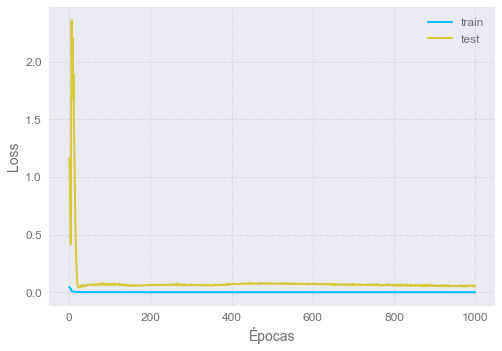

In [14]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(fontsize=12)

In [15]:
y_train_pr = model.predict(x_train_total)
y_test_pr = model.predict(x_test_total)
y_train_pr = scaler.inverse_transform(y_train_pr)
y_test_pr = scaler.inverse_transform(y_test_pr)
y_train =  scaler.inverse_transform(y_train_total)
y_test = scaler.inverse_transform(y_test_total)
print('train mse squared:',mean_squared_error(y_train_total,y_train)) 
print('test mse squared:',mean_squared_error(y_test_total,y_test)) 

train mse squared: 17102.522097148147
test mse squared: 432389.4759310453


# veo como se ajustan a los train y test data para distintas localidades

RiesgoBariloche
train mse: 578.3984334106374
test mse: 1205.306640472167
train r2: 0.9449652233626926
test r2: 0.8554024199110097
train mae: 10.739659915200667
test mae: 24.73090092192528
forecast mse: 3477.1278196308353


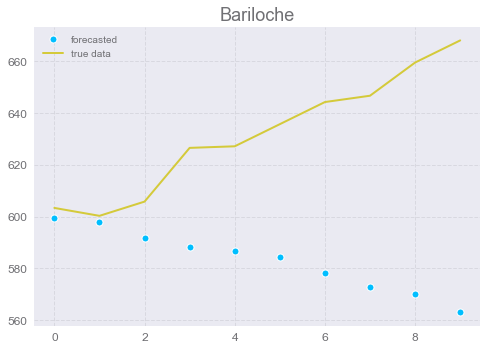

RiesgoBuenosAires
train mse: 82.10004957665278
test mse: 1904.5285125503553
train r2: 0.9961364260796801
test r2: 0.4526994692070968
train mae: 4.486546430900225
test mae: 34.19541687087392
forecast mse: 1508.8245246323972


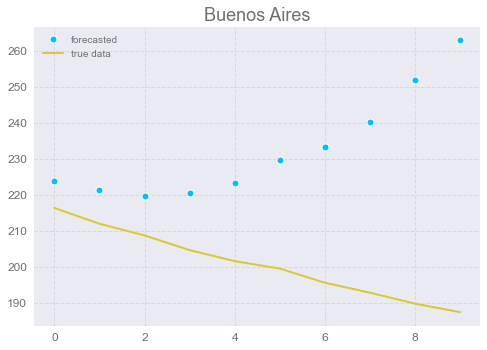

RiesgoCABACABANA
train mse: 94.7060043869108
test mse: 2272.1122267099345
train r2: 0.9980476058577106
test r2: 0.5557410507173892
train mae: 5.953551600855248
test mae: 37.083464810495386
forecast mse: 1376.7680745752536


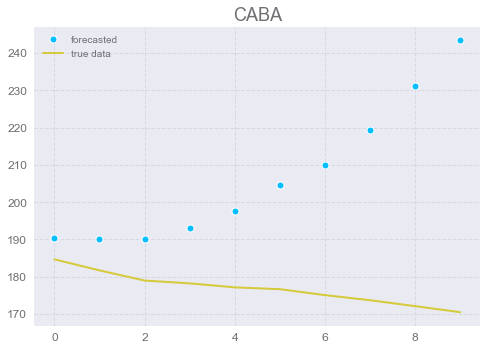

RiesgoChacoNA
train mse: 89.86406334859726
test mse: 1027.8388758266592
train r2: 0.913709916887272
test r2: -0.6012397478529781
train mae: 5.713775645975303
test mae: 21.962515615822415
forecast mse: 429.06475724924456


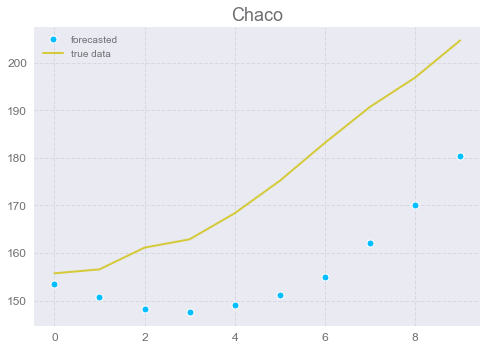

RiesgoCórdobaCórdoba
train mse: 17.057303939761468
test mse: 2714.260206098018
train r2: 0.9857238315185883
test r2: 0.41304982115350397
train mae: 2.1296865208035043
test mae: 39.36768002002929
forecast mse: 1853.7382621490783


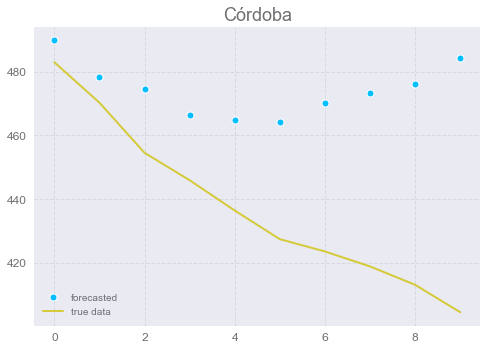

RiesgoEntreRiosRíos
train mse: 69.70559391059749
test mse: 619.7839378172296
train r2: 0.9625271411098204
test r2: 0.827622935619702
train mae: 3.699611167810821
test mae: 17.003351427641665
forecast mse: 678.200458421152


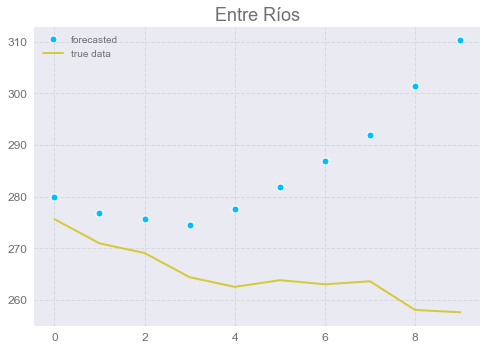

RiesgoJujuyJujuy
train mse: 198.97290758923074
test mse: 1024.4511896352674
train r2: 0.9934030371879705
test r2: 0.5219827962242032
train mae: 7.095639566784129
test mae: 19.798055080838942
forecast mse: 48.02672960099116


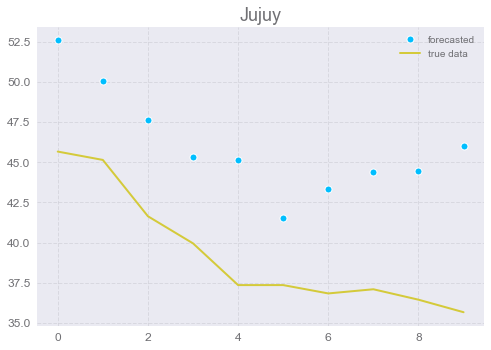

RiesgoLaRiojaRioja
train mse: 84.73696659043644
test mse: 2895.341192998358
train r2: 0.9891087759581939
test r2: 0.6249813486063733
train mae: 5.0754905147432625
test mae: 40.8832179973252
forecast mse: 732.2168661855783


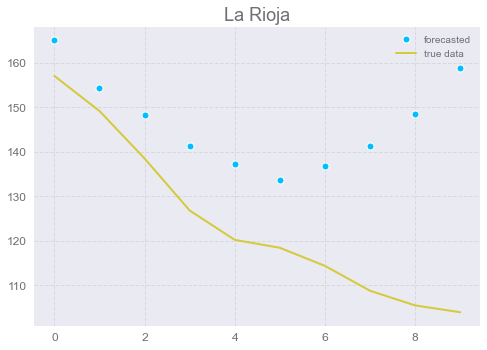

RiesgoMendozaMendoza
train mse: 38.021158397423946
test mse: 2073.563137268984
train r2: 0.9971663209482275
test r2: 0.7265245306437782
train mae: 3.066897909537911
test mae: 31.785074991174824
forecast mse: 4737.418233968133


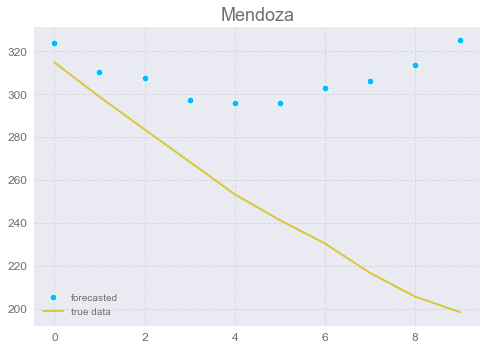

RiesgoNeuquénNeuquén
train mse: 183.50833638355394
test mse: 25217.380860478585
train r2: 0.9876088640889568
test r2: -5.233774063633364
train mae: 5.915215403233922
test mae: 128.1169501388634
forecast mse: 1093.0616521197558


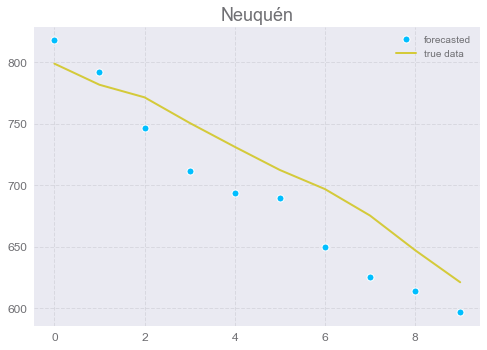

RiesgoRioNegro
train mse: 107.05743932370468
test mse: 5347.982803406366
train r2: 0.9876692709440105
test r2: 0.13545885131048852
train mae: 4.865701363727956
test mae: 56.85803743437359
forecast mse: 202.39714883893845


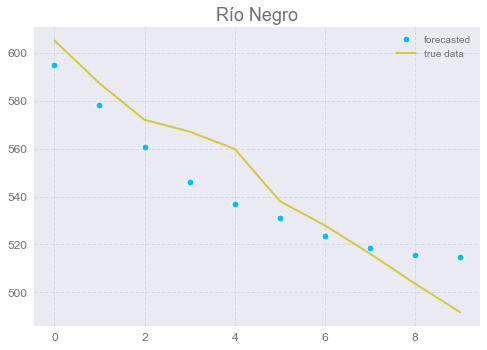

RiesgoSaltaSalta
train mse: 48.0613799992724
test mse: 1448.6648617644098
train r2: 0.9934618768843385
test r2: 0.342790393209232
train mae: 3.372693223393464
test mae: 26.58892514269055
forecast mse: 89.34822448689806


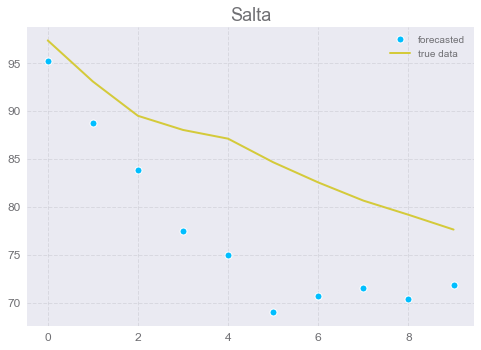

RiesgoSantaCruzSantaCruz
train mse: 214.859667262279
test mse: 6430.752970884766
train r2: 0.9828748538928219
test r2: 0.02626222904519182
train mae: 7.57815699055916
test mae: 59.99348623765779
forecast mse: 17801.957272599462


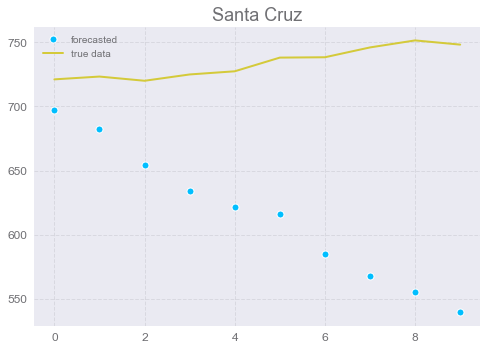

RiesgoSantaFeSantaFe
train mse: 101.40743728136248
test mse: 17621.594140317327
train r2: 0.9909791996830226
test r2: -0.295451247490214
train mae: 3.730317175226539
test mae: 99.79004251822909
forecast mse: 803.2600150712608


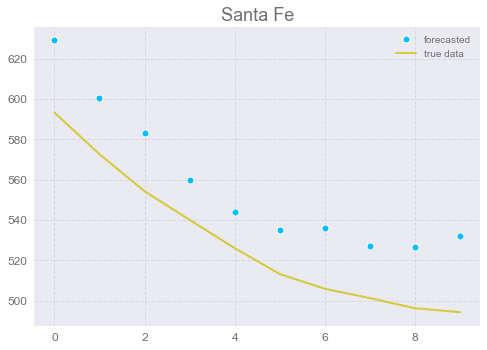

RiesgoTierradelFuegoTierradel
train mse: 522.8355891547966
test mse: 182953.36309075926
train r2: 0.9832362266376724
test r2: -0.4576703728379261
train mae: 11.015879639980874
test mae: 325.60563891728964
forecast mse: 27611.330057073654


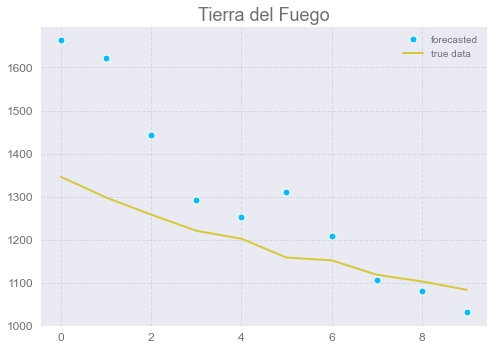

RiesgoTucumanTucuman
train mse: 77.73644635634554
test mse: 18823.33470344697
train r2: 0.9932241389388673
test r2: -0.006444443605795547
train mae: 4.034312035476596
test mae: 96.62576420419256
forecast mse: 221.84029415745354


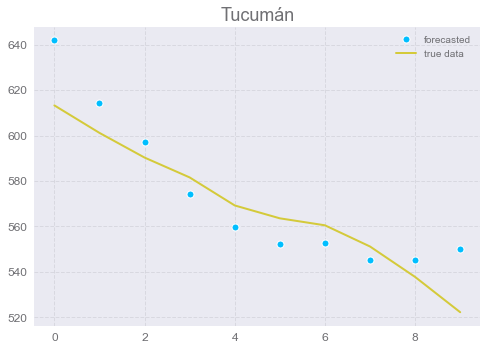

In [24]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df = df[:-10]
    df_original = np.copy(df)
    y_forecast = np.copy(df[-n_steps_in:])
    df = df[:-n_steps_in]
    x_toforecast = np.copy(df[-n_steps_in:])
    x_toforecast = scaler.transform(x_toforecast.reshape(-1,1))
    x_toforecast = x_toforecast.flatten()
    x_toforecast = x_toforecast.reshape(1,1,n_steps_in)
    y_forecasted = model.predict(x_toforecast)
    y_forecasted = scaler.inverse_transform(y_forecasted)
    plt.title(dic_localidades[str(file)])
    plt.plot(y_forecasted.flatten(),'o',label='forecasted')
    plt.plot(y_forecast,label='true data')
    plt.legend()
    #ahora metricas de train y test
    total_size = df_original.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df_original[:-test_size]
    test_data = df_original[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    x_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
    x_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
    x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
    x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1])
    y_train =  y_train.reshape(y_train.shape[0],y_train.shape[1])
    y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
    y_train_pr = model.predict(x_train)
    y_test_pr = model.predict(x_test)
    y_train_pr  = scaler.inverse_transform(y_train_pr.reshape(-1,1))
    y_test_pr = scaler.inverse_transform(y_test_pr.reshape(-1,1))
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1)) 
    #imprimo mse para train y test
    print('train mse:',mean_squared_error(y_train,y_train_pr)) 
    print('test mse:',mean_squared_error(y_test,y_test_pr))
    #imprimo r2
    print('train r2:',r2_score(y_train,y_train_pr)) 
    print('test r2:',r2_score(y_test,y_test_pr)) 
    #imprimo mae
    print('train mae:',mean_absolute_error(y_train,y_train_pr)) 
    print('test mae:',mean_absolute_error(y_test,y_test_pr))
    #forecast error
    print('forecast mse:',mean_squared_error(y_forecast.flatten(),y_forecasted.flatten()))
    plt.show()

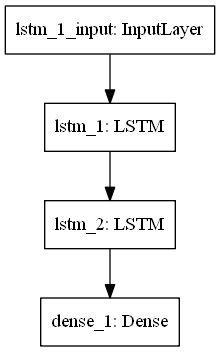

In [17]:
tf.keras.utils.plot_model( model, to_file="model.png", show_shapes=False, show_layer_names=True, rankdir="TB")